In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import losses

import menpo.io as mio
from pathlib import Path
from menpo.landmark import face_ibug_68_to_face_ibug_68

In [2]:
sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

In [3]:
from sklearn.cross_decomposition import CCA
X = np.random.rand(50, 50).astype(np.float32)
Y = np.random.rand(50, 50).astype(np.float32)
cca = CCA(n_components=50)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

/vol/atlas/homes/gt108/miniconda/envs/menpo/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:314: UserWarning: X scores are null at iteration 2
  warnings.warn('X scores are null at iteration %s' % k)


In [4]:
slim = tf.contrib.slim

In [5]:
from menpo.visualize import print_progress

In [6]:
samples = []

for path in print_progress(list(Path('/vol/atlas/homes/gt108/db/MMI_smile/').glob('*_frames'))):
    try:
        images = mio.import_images(path)
        cropped_images = [im.crop_to_pointcloud_proportion(face_ibug_68_to_face_ibug_68(im.landmarks[None])['mouth'], .1) for im in images]
        cropped_images = [im.as_greyscale().resize((20, 45)).pixels[0] for im in cropped_images]
        cropped_images = np.array(cropped_images)
        samples.append(cropped_images)
    except Exception as e:
        print(e)    
        

[========            ] 40% (20/49) - 00:00:42 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S046-010_frames yields no assets
[===========         ] 57% (28/49) - 00:00:28 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S032-007_frames yields no assets
[============        ] 63% (31/49) - 00:00:23 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S034-006_frames yields no assets
[=============       ] 65% (32/49) - 00:00:21 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S040-009_frames yields no assets
[=============       ] 67% (33/49) - 00:00:19 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S035-008_frames yields no assets
[=================   ] 87% (43/49) - 00:00:07 remaining                         The glob /vol/atlas/homes/gt108/db/MMI_smile/S033-006_frames yields no assets
[=================== ] 95% (47/49) - 00:00:02 remain

In [7]:
source_images = tf.placeholder(tf.float32, shape=(None, 20, 45, 1))
target_images = tf.placeholder(tf.float32, shape=(None, 20, 45, 1))

In [27]:
def network(images):
    with slim.arg_scope([slim.conv2d, slim.fully_connected], normalizer_fn=slim.batch_norm, outputs_collections='output'):
        net = slim.conv2d(images, 32, 3)
        net = slim.max_pool2d(net, 2) # 9x21
        net = slim.conv2d(net, 32, 3) # 7x19
        net = slim.max_pool2d(net, 2) # 3x9
        net = slim.flatten(net)
        net = slim.fully_connected(net, 10)
    return net

In [28]:
with tf.variable_scope('net', reuse=False):
    source_proj = network(source_images)
    
with tf.variable_scope('net', reuse=True):
    target_proj = network(target_images)

In [34]:
from menpo.image import Image

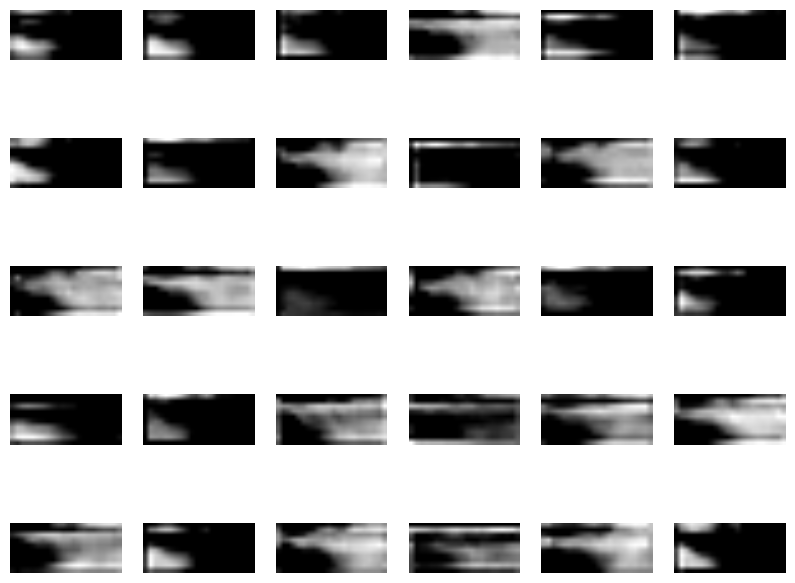

In [42]:
Image.init_from_channels_at_back(sess.run(tf.get_collection('output')[1], 
    feed_dict={source_images: samples[0][:50][..., None], target_images: samples[1][:50][..., None]})[0]
).view_widget()

In [10]:
cost, Cxx = losses.correlation_cost(source_proj, target_proj, 0, 0)

opt = tf.train.AdamOptimizer(.001)
train_op = opt.minimize(cost)

In [11]:
sess.run(tf.initialize_all_variables())

In [12]:
cov = sess.run(Cxx, feed_dict={source_images: samples[0][:50][..., None], target_images: samples[1][:50][..., None]})

In [16]:
Ps = [np.linspace(0, x.shape[0]-1, max(x.shape[0] for x in samples)).round().astype(int) for x in samples]

In [19]:
Ps[1]

array([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
        6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22,
       22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27,
       28, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33,
       33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38,
       39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44,
       44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49,
       50, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55,
       55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60,
       61, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66,
       66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71,
       72, 72, 72, 72, 73

In [26]:
for _ in range(100):
    errors = []
    for i in range(len(samples)):
        for j in range(len(samples)):
            if i == j: continue
                
            source = samples[i][Ps[i]][..., None].copy()
            target = samples[j][Ps[j]][..., None].copy()

            l, _ = sess.run([cost, train_op], feed_dict={source_images: source, target_images: target})
            errors.append(l[0])
            print(np.mean(errors))

-246.14
-160.309
-159.059
-133.941
-129.2
-170.88
-165.072
-235.722
-266.498
-241.324
-229.807
-218.159


KeyboardInterrupt: 

In [18]:
import functools
def correlation(X, Y, dimensions=None):
    m, n = X.shape[0], Y.shape[0]
    if dimensions is None:
        dimensions = m
    assert m <= 100

    sx, sy =  m, n
    C = np.cov(X, Y)
    Cxx = C[0:sx, 0:sx] + np.eye(sx) * 1e-6
    Cxy = C[0:sx, sx:]
    Cyx = Cxy.T
    Cyy = C[sx:, sx:] + np.eye(sy) * 1e-6

    Rx = np.linalg.inv(np.linalg.cholesky(Cxx).T)
    Ry = np.linalg.inv(np.linalg.cholesky(Cyy).T)
    corr = functools.reduce(np.dot, (Rx, Cxy, Ry))

    return np.trace(corr)

In [19]:
correlation(X_c, Y_c)

-285.63901019544352

In [20]:
sess.run(PX).shape

(50, 11)

In [21]:
X_c

array([[ 0.12827546, -0.14901106,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12612248, -0.47583125,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00530706, -0.05233381,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.06790103, -0.22406158,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03403901, -0.21972426,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07764905,  0.44965735,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
correlation(*sess.run([PX, PY]))

-480.102499492265